stayed = 1, churned = 0

In [59]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
from xgboost import plot_importance
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay

from scipy.special import softmax

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMClassifier
import shap

In [2]:
prc = pd.read_csv('/Users/yoonjihun/Downloads/Churn.csv', encoding = 'euc-kr')

In [3]:
prc = prc[prc['customer_status']!= 'Joined']

In [4]:
prc.customer_status

0        Stayed
1        Stayed
2       Churned
3       Churned
4       Churned
         ...   
7037    Churned
7038     Stayed
7039    Churned
7041     Stayed
7042     Stayed
Name: customer_status, Length: 6589, dtype: object

In [5]:
object_col = ['customer_status']

# fit()과 transform()으로 라벨 인코딩을 수행
for feature in object_col:
    # LabelEncoder를 객체로 생성
    encoder = LabelEncoder()
    # fit, transform 메소드를 통한 레이블 인코딩
    encoder.fit(prc[feature])
    prc[feature] = encoder.transform(prc[feature])

In [6]:
prc.customer_status

0       1
1       1
2       0
3       0
4       0
       ..
7037    0
7038    1
7039    0
7041    1
7042    1
Name: customer_status, Length: 6589, dtype: int32

In [7]:
# prc = prc.drop(['churn'], axis = 1)

In [8]:
prc = prc[['contract', 'number_of_referrals', 'tenure_in_months', 'premium_tech_support', 'monthly_charge', 'online_security', 'age', 'total_charges', 'customer_status']]

In [9]:
prc.columns

Index(['contract', 'number_of_referrals', 'tenure_in_months',
       'premium_tech_support', 'monthly_charge', 'online_security', 'age',
       'total_charges', 'customer_status'],
      dtype='object')

In [10]:
X = prc.drop(['customer_status'], axis = 1)
y = prc['customer_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4612, 8) (1977, 8)
(4612,) (1977,)


In [11]:
# 금액 칼럼 표준화
col = ['tenure_in_months', 'monthly_charge', 'total_charges']

from sklearn.preprocessing import StandardScaler # 데이터 전처리: 표준점수화하기

ss = StandardScaler()
ss.fit(X_train[col])

X_train[col] = ss.transform(X_train[col])
X_test[col] = ss.transform(X_test[col])

In [12]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(tree_method = 'hist'),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10),
    'LightGBM': LGBMClassifier()
}

## Without Cross Validation

In [13]:
# Fit and evaluate models

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = round(accuracy.mean(), 2)
    
    print(f'{model_name}:')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))
    print()

# Voting
# Stacking
# GradientBoosting

Logistic Regression:
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       561
           1       0.90      0.88      0.89      1416

    accuracy                           0.85      1977
   macro avg       0.81      0.82      0.81      1977
weighted avg       0.85      0.85      0.85      1977


Decision Tree:
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       561
           1       0.87      0.86      0.87      1416

    accuracy                           0.81      1977
   macro avg       0.77      0.77      0.77      1977
weighted avg       0.81      0.81      0.81      1977


Random Forest:
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       561
           1       0.88      0.93      0.90      1416

    accuracy                           0.86      1977
   macro avg       0.84      0

## Adding K-fold 

In [14]:
model_names = [] # 각 모델 이름 리스트
acc_results = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_results = []
pre_results = []
rec_results = []
f1_results = []

result_col = ["Algorithm", "Accuracy", "ROC AUC", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
model_results = pd.DataFrame(columns = result_col) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트

# Perform K-fold cross-validation
i=0
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits = 5)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    cv_pre_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    cv_rec_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    cv_f1_results = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    rec_results.append(cv_rec_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [model_name,
                            np.mean(acc_results),
                            np.mean(auc_results),
                            np.mean(pre_results),
                            np.mean(rec_results),
                            np.mean(f1_results)]

    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,Accuracy,ROC AUC,Precision,Recall,f1 Score
0,Logistic Regression,0.834127,0.898892,0.886127,0.881912,0.883896
6,LightGBM,0.848777,0.890780,0.879591,0.912860,0.895807
5,Bagging,0.847062,0.886865,0.879221,0.910386,0.894424
4,XGBoost,0.843536,0.881347,0.879395,0.905344,0.891860
3,Gradient Boosting,0.841606,0.875038,0.879658,0.901715,0.890187
2,Random Forest,0.834342,0.859268,0.878763,0.890912,0.884448
1,Decision Tree,0.822525,0.835052,0.877133,0.871623,0.874612


## Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)


pred_train_lr = lr.predict(X_train) # 훈련세트로 예측하기
pred_test_lr = lr.predict(X_test) # 테스트세트로 예측하기

acc_train_lr = accuracy_score(pred_train_lr, y_train) # 훈련 세트 예측과 훈련 세트 실제 타겟 간의 정확도 확인
acc_test_lr = accuracy_score(pred_test_lr, y_test) # 테스트 세트 예측과 테스트 세트 실제 타겟 간의 정확도 확인

print(f'Training accuracy {acc_train_lr: .3f}') 
print(f'Testing accuracy {acc_test_lr: .3f}')

Training accuracy  0.840
Testing accuracy  0.845


In [16]:
lr = LogisticRegression()

def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_


param1 = {'C':[10, 100, 1000], 'max_iter': [100, 300, 500, 700, 900, 1100]}
tuning_params(X_train, y_train, params = param1, model = lr)

Accuracy
Train score: 0.8404163052905465
Best params: {'C': 100, 'max_iter': 300}
Best estimator:  LogisticRegression(C=100, max_iter=300)
Best score:  0.8378140694660203

ROC_AUC
Train score: 0.9003170561491585
Best params: {'C': 10, 'max_iter': 100}
Best estimator:  LogisticRegression(C=10)
Best score:  0.8997053145761322


(LogisticRegression(C=100, max_iter=300), LogisticRegression(C=10))

Accuracy
Train score: 0.8404163052905465
Best params: {'C': 100, 'max_iter': 300}
Best estimator:  LogisticRegression(C=100, max_iter=300)
Best score:  0.8378140694660203

ROC_AUC
Train score: 0.9003170561491585
Best params: {'C': 10, 'max_iter': 100}
Best estimator:  LogisticRegression(C=10)
Best score:  0.8997053145761322

(LogisticRegression(C=100, max_iter=300), LogisticRegression(C=10))

In [17]:
good_lr = LogisticRegression(C=10, max_iter=100, random_state=42)
good_lr.fit(X_train, y_train)
pred_lr = good_lr.predict(X_test)

print('Results on test data: ')

acc_lr = accuracy_score(y_test, pred_lr)
pre_lr = precision_score(y_test, pred_lr)
rec_lr = recall_score(y_test, pred_lr)
auc_lr = roc_auc_score(y_test, pred_lr)

print(f'Test accuracy = {acc_lr: .4f}') 
print(f'Test precision = {pre_lr: .4f}') 
print(f'Test recall = {rec_lr: .4f}') 
print(f'Test auc = {auc_lr: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_lr))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_lr)))

Results on test data: 
Test accuracy =  0.8447
Test precision =  0.9004
Test recall =  0.8806
Test auc =  0.8173
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       561
           1       0.90      0.88      0.89      1416

    accuracy                           0.84      1977
   macro avg       0.81      0.82      0.81      1977
weighted avg       0.85      0.84      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  423   138
1  169  1247


## Decision Tree

In [18]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

pred_train_dt = dt.predict(X_train)
pred_test_dt = dt.predict(X_test)

acc_train_dt = accuracy_score(pred_train_dt, y_train)
acc_test_dt = accuracy_score(pred_test_dt, y_test)

print(f'Training accuracy {acc_train_dt: .3f}') 
print(f'Testing accuracy {acc_test_dt: .3f}')

Training accuracy  1.000
Testing accuracy  0.814


In [19]:
dt = DecisionTreeClassifier()

def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_


param1 = {'criterion':['gini', 'entropy'], 'max_depth':[None,2,3,4,5,6]}
tuning_params(X_train, y_train, params = param1, model = dt)

Accuracy
Train score: 0.8683868169991327
Best params: {'criterion': 'entropy', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6)
Best score:  0.8532116107289489

ROC_AUC
Train score: 0.9279265333096386
Best params: {'criterion': 'gini', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(max_depth=6)
Best score:  0.9035783837091012


(DecisionTreeClassifier(criterion='entropy', max_depth=6),
 DecisionTreeClassifier(max_depth=6))

Accuracy
Train score: 0.8683868169991327
Best params: {'criterion': 'entropy', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=6)
Best score:  0.8532116107289489

ROC_AUC
Train score: 0.9279265333096386
Best params: {'criterion': 'gini', 'max_depth': 6}
Best estimator:  DecisionTreeClassifier(max_depth=6)
Best score:  0.9035783837091012

(DecisionTreeClassifier(criterion='entropy', max_depth=6),
 DecisionTreeClassifier(max_depth=6))

In [20]:
good_dt = DecisionTreeClassifier(criterion='gini', max_depth=6)
good_dt.fit(X_train, y_train)
pred_dt = good_dt.predict(X_test)

print('Results on test data: ')

acc_dt = accuracy_score(y_test, pred_dt)
pre_dt = precision_score(y_test, pred_dt)
rec_dt = recall_score(y_test, pred_dt)
auc_dt = roc_auc_score(y_test, pred_dt)

print(f'Test accuracy = {acc_dt: .4f}') 
print(f'Test precision = {pre_dt: .4f}') 
print(f'Test recall = {rec_dt: .4f}') 
print(f'Test auc = {auc_dt: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_dt))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_dt)))

Results on test data: 
Test accuracy =  0.8584
Test precision =  0.8698
Test recall =  0.9435
Test auc =  0.7935
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       561
           1       0.87      0.94      0.91      1416

    accuracy                           0.86      1977
   macro avg       0.84      0.79      0.81      1977
weighted avg       0.86      0.86      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  361   200
1   80  1336


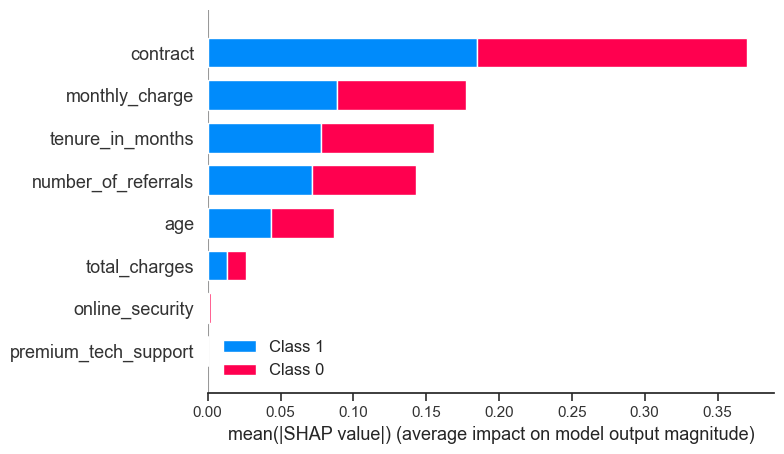

In [49]:
# 특성중요도 시각화
explainer = shap.TreeExplainer(good_dt)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X_train)

## Random Forest

In [21]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)


pred_train_rf = rf.predict(X_train) # 훈련세트로 예측하기
pred_test_rf = rf.predict(X_test) # 테스트세트로 예측하기

acc_train_rf = accuracy_score(pred_train_rf, y_train) # 훈련 세트 예측과 훈련 세트 실제 타겟 간의 정확도 확인
acc_test_rf = accuracy_score(pred_test_rf, y_test) # 테스트 세트 예측과 테스트 세트 실제 타겟 간의 정확도 확인

print(f'Training accuracy {acc_train_rf: .3f}') 
print(f'Testing accuracy {acc_test_rf: .3f}')

Training accuracy  1.000
Testing accuracy  0.864


In [22]:
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

param1 = [{'n_estimators': [25, 50, 75],
           'max_features': [15, 20, 25],
           'max_leaf_nodes': [8, 16, 24]}]
tuning_params(X_train, y_train, params = param1, model = rf)

Accuracy
Train score: 0.8742411101474414
Best params: {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 25}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=25,
                       random_state=42)
Best score:  0.866218569551801

ROC_AUC
Train score: 0.9348411664852537
Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 75}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75,
                       random_state=42)
Best score:  0.9180368679010769


(RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=25,
                        random_state=42),
 RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75,
                        random_state=42))

Accuracy
Train score: 0.8742411101474414
Best params: {'max_features': 15, 'max_leaf_nodes': 16, 'n_estimators': 25}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=25,
                       random_state=42)
Best score:  0.866218569551801

ROC_AUC
Train score: 0.9348411664852537
Best params: {'max_features': 15, 'max_leaf_nodes': 24, 'n_estimators': 75}
Best estimator:  RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75,
                       random_state=42)
Best score:  0.9180368679010769

(RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=25,
                        random_state=42),
 RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75,
                        random_state=42))

In [23]:
good_rf = RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75, random_state=42)

good_rf.fit(X_train, y_train)
pred_rf = good_rf.predict(X_test)

print('Results on test data: ')

acc_rf = accuracy_score(y_test, pred_rf)
pre_rf = precision_score(y_test, pred_rf)
rec_rf = recall_score(y_test, pred_rf)
auc_rf = roc_auc_score(y_test, pred_rf)

print(f'Test accuracy = {acc_rf: .4f}') 
print(f'Test precision = {pre_rf: .4f}') 
print(f'Test recall = {rec_rf: .4f}') 
print(f'Test auc = {auc_rf: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_rf))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_rf)))

Results on test data: 
Test accuracy =  0.8690
Test precision =  0.8849
Test recall =  0.9393
Test auc =  0.8154
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       561
           1       0.88      0.94      0.91      1416

    accuracy                           0.87      1977
   macro avg       0.85      0.82      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  388   173
1   86  1330


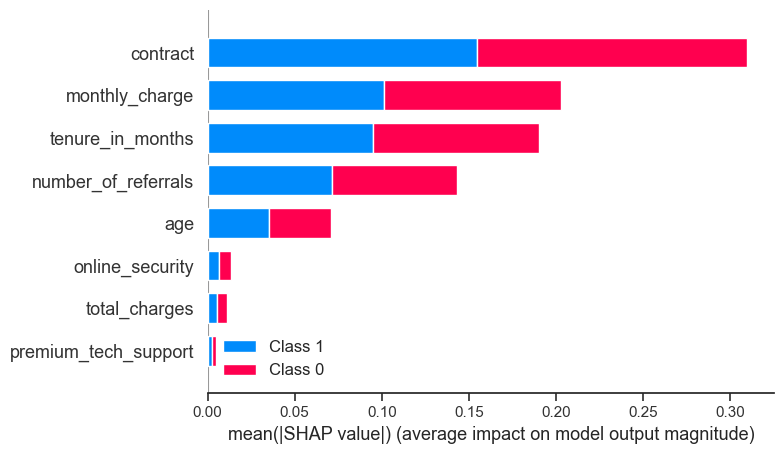

In [57]:
# 특성중요도 시각화
explainer = shap.TreeExplainer(good_rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X_train)

## Bagging

In [24]:
# 순정 테스트
bag = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42), 
                        random_state = 42, n_jobs = -1)

bag.fit(X_train, y_train)
pred_train_bag = bag.predict(X_train)
pred_test_bag = bag.predict(X_test)

acc_train_bag = accuracy_score(pred_train_bag, y_train) # 훈련 세트 예측과 훈련 세트 실제 타겟 간의 정확도 확인
acc_test_bag = accuracy_score(pred_test_bag, y_test) # 테스트 세트 예측과 테스트 세트 실제 타겟 간의 정확도 확인

print(f'Training accuracy {acc_train_rf: .3f}') 
print(f'Testing accuracy {acc_test_rf: .3f}')

Training accuracy  1.000
Testing accuracy  0.864


In [25]:
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

# (max_features=25, max_leaf_nodes=24, n_estimators=75, random_state=42)
# bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1)
# (DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)
param1 = [{'n_estimators': [100, 200, 300, 10, 50],
          'max_samples': [10, 100, 1000],
          }]
tuning_params(X_train, y_train, params = param1, model = bag)

Accuracy
Train score: 0.8944058976582827
Best params: {'max_samples': 1000, 'n_estimators': 300}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=1000, n_estimators=300, n_jobs=-1,
                  random_state=42)
Best score:  0.8666512339513469

ROC_AUC
Train score: 0.9634719013557841
Best params: {'max_samples': 1000, 'n_estimators': 100}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=1000, n_estimators=100, n_jobs=-1,
                  random_state=42)
Best score:  0.9189424471134494


(BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=1000, n_estimators=300, n_jobs=-1,
                   random_state=42),
 BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=1000, n_estimators=100, n_jobs=-1,
                   random_state=42))

Accuracy
Train score: 0.8944058976582827
Best params: {'max_samples': 1000, 'n_estimators': 300}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=1000, n_estimators=300, n_jobs=-1,
                  random_state=42)
Best score:  0.8666512339513469

ROC_AUC
Train score: 0.9634719013557841
Best params: {'max_samples': 1000, 'n_estimators': 100}
Best estimator:  BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                  max_samples=1000, n_estimators=100, n_jobs=-1,
                  random_state=42)
Best score:  0.9189424471134494

(BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=1000, n_estimators=300, n_jobs=-1,
                   random_state=42),
 BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                   max_samples=1000, n_estimators=100, n_jobs=-1,
                   random_state=42))

In [26]:
good_bag = BaggingClassifier(base_estimator=RandomForestClassifier(max_features=25, max_leaf_nodes=24, n_estimators=75, random_state=42), 
                             max_samples=1000, n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
good_bag.fit(X_train, y_train)
pred_bag = good_bag.predict(X_test)

print('Results on test data: ')

acc_bag = accuracy_score(y_test, pred_bag)
pre_bag = precision_score(y_test, pred_bag)
rec_bag = recall_score(y_test, pred_bag)
auc_bag = roc_auc_score(y_test, pred_bag)

print(f'Test accuracy = {acc_bag: .4f}') 
print(f'Test precision = {pre_bag: .4f}') 
print(f'Test recall = {rec_bag: .4f}') 
print(f'Test auc = {auc_bag: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_bag))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_bag)))

Results on test data: 
Test accuracy =  0.8771
Test precision =  0.8826
Test recall =  0.9555
Test auc =  0.8173
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76       561
           1       0.88      0.96      0.92      1416

    accuracy                           0.88      1977
   macro avg       0.87      0.82      0.84      1977
weighted avg       0.88      0.88      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  381   180
1   63  1353


## Gradient Boosting

In [27]:
gb = GradientBoostingClassifier(random_state = 42)
scores = cross_validate(gb, X_train, y_train, return_train_score = True, n_jobs = -1) # 교차검증 + 정확도 확인

print("Train Score:", np.mean(scores['train_score']))
print("Test Score:", np.mean(scores['test_score']))

gb.fit(X_train, y_train)

pred_train_gb = gb.predict(X_train)
pred_test_gb = gb.predict(X_test)

acc_train_gb = accuracy_score(pred_train_gb, y_train)
acc_test_gb = accuracy_score(pred_test_gb, y_test)

print(f'Training accuracy {acc_train_gb: .3f}') 
print(f'Testing accuracy {acc_test_gb: .3f}')

Train Score: 0.8874674065797313
Test Score: 0.8642667619264728
Training accuracy  0.886
Testing accuracy  0.870


In [28]:
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

param1 = [{'n_estimators': [80, 100, 150, 200, 500],
         'learning_rate': [0.1, 0.2, 0.3],
         'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = gb)


Accuracy
Train score: 0.8818300086730269
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Best estimator:  GradientBoostingClassifier(n_estimators=80, random_state=42)
Best score:  0.8655673403007734

ROC_AUC
Train score: 0.9417455026249343
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Best estimator:  GradientBoostingClassifier(n_estimators=80, random_state=42)
Best score:  0.9231924290253559


(GradientBoostingClassifier(n_estimators=80, random_state=42),
 GradientBoostingClassifier(n_estimators=80, random_state=42))

Accuracy
Train score: 0.8818300086730269
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Best estimator:  GradientBoostingClassifier(n_estimators=80, random_state=42)
Best score:  0.8655673403007734

ROC_AUC
Train score: 0.9417455026249343
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Best estimator:  GradientBoostingClassifier(n_estimators=80, random_state=42)
Best score:  0.9231924290253559

(GradientBoostingClassifier(n_estimators=80, random_state=42),
 GradientBoostingClassifier(n_estimators=80, random_state=42))

In [29]:
good_gb = GradientBoostingClassifier(n_estimators = 80, learning_rate = 0.1, max_depth = 3, random_state = 42)
                            # learning_rate GB의 중요한 매개변수. 이전 트리의 오차를 얼마나 강하게 보정할 것인지를 제어
                            # n_estimators 트리 더 많이 추가. 모델의 복잡도가 커지고 훈련 세트에서의 실수를 바로 잡을 기회가 더 많아짐

good_gb.fit(X_train, y_train)
pred_gb = good_gb.predict(X_test)

print('Results on test data: ')

acc_gb = accuracy_score(y_test, pred_gb)
pre_gb = precision_score(y_test, pred_gb)
rec_gb = recall_score(y_test, pred_gb)
auc_gb = roc_auc_score(y_test, pred_gb)

print(f'Test accuracy = {acc_gb: .4f}') 
print(f'Test precision = {pre_gb: .4f}') 
print(f'Test recall = {rec_gb: .4f}') 
print(f'Test auc = {auc_gb: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_gb))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_gb)))

Results on test data: 
Test accuracy =  0.8715
Test precision =  0.8858
Test recall =  0.9421
Test auc =  0.8177
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       561
           1       0.89      0.94      0.91      1416

    accuracy                           0.87      1977
   macro avg       0.86      0.82      0.83      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  389   172
1   82  1334


## XGBoost

In [30]:
xgb =XGBClassifier(tree_method = 'hist', random_state = 42) # (n_estimators=700, learning_rate=0.1, max_depth=3)
xgb.fit(X_train,y_train)

pred_train_xgb = xgb.predict(X_train)
pred_test_xgb = xgb.predict(X_test)

acc_train_xgb = accuracy_score(pred_train_xgb, y_train)
acc_test_xgb = accuracy_score(pred_test_xgb, y_test)

print(f'Training accuracy {acc_train_xgb: .3f}') 
print(f'Testing accuracy {acc_test_xgb: .3f}')

Training accuracy  0.980
Testing accuracy  0.861


In [31]:
def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_

param1 = [{'n_estimators': [100, 300, 500, 700],
           'learning_rate': [0.1, 0.2, 0.3],
           'max_depth': [1, 3, 5, 7, 9]}]

tuning_params(X_train, y_train, params = param1, model = xgb)

Accuracy
Train score: 0.8783607979184735
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best score:  0.8642655868466262

ROC_AUC
Train score: 0.9408738411785177
Best params: {'learning_rate': 0.1, 'max_depth': 3

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric

Accuracy
Train score: 0.8783607979184735
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best score:  0.8642655868466262

ROC_AUC
Train score: 0.9408738411785177
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
Best score:  0.9242402255842203

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...))

In [32]:
good_xgb = XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42)

evals = [(X_test, y_test)]
good_xgb.fit(X_train, y_train, 
             early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True)
pred_xgb = good_xgb.predict(X_test)


print('Results on test data: ')

acc_xgb = accuracy_score(y_test, pred_xgb)
pre_xgb = precision_score(y_test, pred_xgb)
rec_xgb = recall_score(y_test, pred_xgb)
auc_xgb = roc_auc_score(y_test, pred_xgb)

print(f'Test accuracy = {acc_xgb: .4f}') 
print(f'Test precision = {pre_xgb: .4f}') 
print(f'Test recall = {rec_xgb: .4f}') 
print(f'Test auc = {auc_xgb: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_xgb))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_xgb)))

[0]	validation_0-logloss:0.64216
[1]	validation_0-logloss:0.59941
[2]	validation_0-logloss:0.56471
[3]	validation_0-logloss:0.53479
[4]	validation_0-logloss:0.50886
[5]	validation_0-logloss:0.48719
[6]	validation_0-logloss:0.46843
[7]	validation_0-logloss:0.45209
[8]	validation_0-logloss:0.43714
[9]	validation_0-logloss:0.42449
[10]	validation_0-logloss:0.41351
[11]	validation_0-logloss:0.40268
[12]	validation_0-logloss:0.39349
[13]	validation_0-logloss:0.38486
[14]	validation_0-logloss:0.37808
[15]	validation_0-logloss:0.37138
[16]	validation_0-logloss:0.36517
[17]	validation_0-logloss:0.36032
[18]	validation_0-logloss:0.35502
[19]	validation_0-logloss:0.35058
[20]	validation_0-logloss:0.34527
[21]	validation_0-logloss:0.34203
[22]	validation_0-logloss:0.33895
[23]	validation_0-logloss:0.33561
[24]	validation_0-logloss:0.33280
[25]	validation_0-logloss:0.33054
[26]	validation_0-logloss:0.32699
[27]	validation_0-logloss:0.32482
[28]	validation_0-logloss:0.32225
[29]	validation_0-loglos

## LightGBM

In [33]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

pred_train_lgbm = lgbm.predict(X_train)
pred_test_lgbm = lgbm.predict(X_test)

acc_train_lgbm = accuracy_score(pred_train_lgbm, y_train)
acc_test_lgbm = accuracy_score(pred_test_lgbm, y_test)

print(f'Training accuracy {acc_train_lgbm: .3f}') 
print(f'Testing accuracy {acc_test_lgbm: .3f}')

Training accuracy  0.941
Testing accuracy  0.871


In [34]:
lgbm = LGBMClassifier()

def tuning_params(X, y, params, model):
    gs_acc = GridSearchCV(model, params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    gs_auc = GridSearchCV(model, params, scoring = 'roc_auc', cv = 5, n_jobs = -1)
    
    gs_acc.fit(X, y)
    gs_auc.fit(X, y)
    
    print('Accuracy')
    print('Train score:', gs_acc.score(X_train, y_train))
    print('Best params:', gs_acc.best_params_)
    print("Best estimator: ", gs_acc.best_estimator_)
    print("Best score: ", gs_acc.best_score_)
    
    print('\nROC_AUC')
    print('Train score:', gs_auc.score(X_train, y_train))
    print('Best params:', gs_auc.best_params_)
    print("Best estimator: ", gs_auc.best_estimator_)
    print("Best score: ", gs_auc.best_score_)
    
    return gs_acc.best_estimator_, gs_auc.best_estimator_


param1 = [{'n_estimators': [100, 300, 500, 700],
           'learning_rate': [0.1, 0.2, 0.3],
           'max_depth': [1, 3, 5, 7, 9]}]
tuning_params(X_train, y_train, params = param1, model = lgbm)

Accuracy
Train score: 0.8712055507372073
Best params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}
Best estimator:  LGBMClassifier(max_depth=1, n_estimators=500)
Best score:  0.8653499505291384

ROC_AUC
Train score: 0.94337567381952
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3)
Best score:  0.9236810951588748


(LGBMClassifier(max_depth=1, n_estimators=500), LGBMClassifier(max_depth=3))

Accuracy
Train score: 0.8712055507372073
Best params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}
Best estimator:  LGBMClassifier(max_depth=1, n_estimators=500)
Best score:  0.8653499505291384

ROC_AUC
Train score: 0.94337567381952
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best estimator:  LGBMClassifier(max_depth=3)
Best score:  0.9236810951588748

(LGBMClassifier(max_depth=1, n_estimators=500), LGBMClassifier(max_depth=3))

In [35]:
good_lgbm = LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100)
good_lgbm.fit(X_train, y_train)
pred_lgbm = good_lgbm.predict(X_test)

print('Results on test data: ')

acc_lgbm = accuracy_score(y_test, pred_lgbm)
pre_lgbm = precision_score(y_test, pred_lgbm)
rec_lgbm = recall_score(y_test, pred_lgbm)
auc_lgbm = roc_auc_score(y_test, pred_lgbm)

print(f'Test accuracy = {acc_lgbm: .4f}') 
print(f'Test precision = {pre_lgbm: .4f}') 
print(f'Test recall = {rec_lgbm: .4f}') 
print(f'Test auc = {auc_lgbm: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_lgbm))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_lgbm)))

Results on test data: 
Test accuracy =  0.8735
Test precision =  0.8881
Test recall =  0.9421
Test auc =  0.8213
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       561
           1       0.89      0.94      0.91      1416

    accuracy                           0.87      1977
   macro avg       0.86      0.82      0.84      1977
weighted avg       0.87      0.87      0.87      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  393   168
1   82  1334


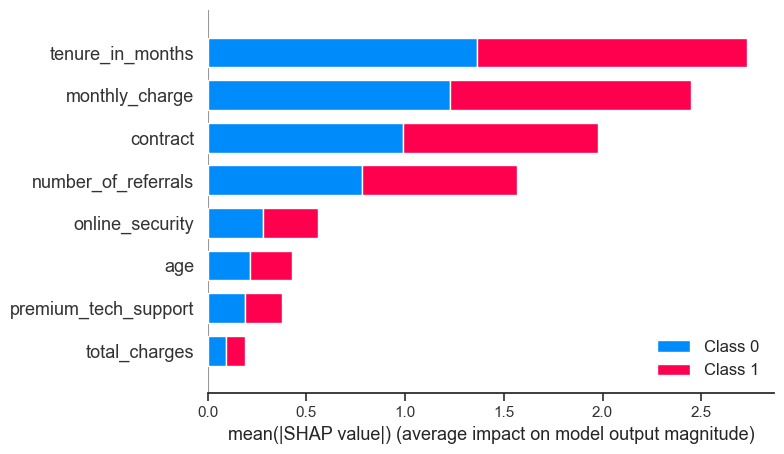

In [58]:
# 특성 중요도 시각화
explainer = shap.TreeExplainer(good_lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X_train)

In [36]:
models = {
    'Logistic Regression': LogisticRegression(C=10, max_iter=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=6),
    'Random Forest': RandomForestClassifier(max_features=15, max_leaf_nodes=24, n_estimators=75, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators = 80, learning_rate = 0.1, max_depth = 3, random_state = 42),
    'XGBoost': XGBClassifier(tree_method = 'hist', learning_rate = 0.1, max_depth = 3, n_estimators = 100, random_state = 42),
    'Bagging': BaggingClassifier(base_estimator=RandomForestClassifier(max_features=25, max_leaf_nodes=24, n_estimators=75, random_state=42), 
                             max_samples=1000, n_estimators=100, n_jobs=-1, oob_score=True, random_state=42),
    'LightGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 100)
}

In [37]:
model_names_opt = [] # 각 모델 이름 리스트
acc_results_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_results_opt = []
pre_results_opt = []
rec_results_opt = []
f1_results_opt = []

result_col_opt = ["Algorithm", "Accuracy", "ROC AUC", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
model_results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트

# Perform K-fold cross-validation
i=0
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_train, y_train, cv = kf, scoring = 'f1')

    acc_results.append(acc_results_opt)
    auc_results.append(auc_results_opt)
    pre_results.append(pre_results_opt)
    rec_results.append(rec_results_opt)
    f1_results.append(f1_results_opt)
    
    model_results.loc[i] = [model_name,
                            np.mean(acc_results),
                            np.mean(auc_results),
                            np.mean(pre_results),
                            np.mean(rec_results),
                            np.mean(f1_results)]

    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,Accuracy,ROC AUC,Precision,Recall,f1 Score
6,LightGBM,0.854198,0.903247,0.878911,0.923276,0.900329
5,Bagging,0.853374,0.901694,0.878699,0.922189,0.899693
4,XGBoost,0.852502,0.900306,0.879062,0.920214,0.898945
3,Gradient Boosting,0.851157,0.898169,0.878816,0.918320,0.897904
2,Random Forest,0.849629,0.895667,0.878441,0.916288,0.896727
1,Decision Tree,0.847810,0.893187,0.878789,0.912769,0.895234
0,Logistic Regression,0.847162,0.891827,0.880679,0.908995,0.894455


In [38]:
model_names_opt = [] # 각 모델 이름 리스트
acc_results_opt = [] # 검증세트 정확도 점수 저장할 리스트 생성
auc_results_opt = []
pre_results_opt = []
rec_results_opt = []
f1_results_opt = []

result_col_opt = ["Algorithm", "Accuracy", "ROC AUC", "Precision", "Recall", "f1 Score"] # 데이터 프레임 칼럼 리스트
model_results_opt = pd.DataFrame(columns = result_col_opt) # 데이터 프레임 생성, 칼럼은 상위 칼럼 리스트

# Perform K-fold cross-validation
i=0
for model_name, model in models.items():
    model_names.append(model_name)
    kf = KFold(n_splits = 5)
    
    acc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'accuracy')
    auc_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'roc_auc')
    pre_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'precision')
    rec_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'recall')
    f1_results_opt = model_selection.cross_val_score(model, X_test, y_test, cv = kf, scoring = 'f1')

    acc_results.append(acc_results_opt)
    auc_results.append(auc_results_opt)
    pre_results.append(pre_results_opt)
    rec_results.append(rec_results_opt)
    f1_results.append(f1_results_opt)
    
    model_results.loc[i] = [model_name,
                            np.mean(acc_results),
                            np.mean(auc_results),
                            np.mean(pre_results),
                            np.mean(rec_results),
                            np.mean(f1_results)]

    i+=1

model_results.sort_values(by = ['ROC AUC'], ascending=False)


,Algorithm,Accuracy,ROC AUC,Precision,Recall,f1 Score
6,LightGBM,0.856598,0.907051,0.879212,0.927145,0.902255
5,Bagging,0.855979,0.906102,0.879019,0.926393,0.901796
4,XGBoost,0.855294,0.905359,0.879171,0.925042,0.901241
3,Gradient Boosting,0.854646,0.904295,0.878964,0.924246,0.900756
2,Random Forest,0.853832,0.903119,0.878661,0.923314,0.900156
0,Logistic Regression,0.853228,0.902422,0.879493,0.920996,0.899519
1,Decision Tree,0.853043,0.902045,0.878869,0.921700,0.899509


### roc 곡선 그리기

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

모든 모델 roc곡선

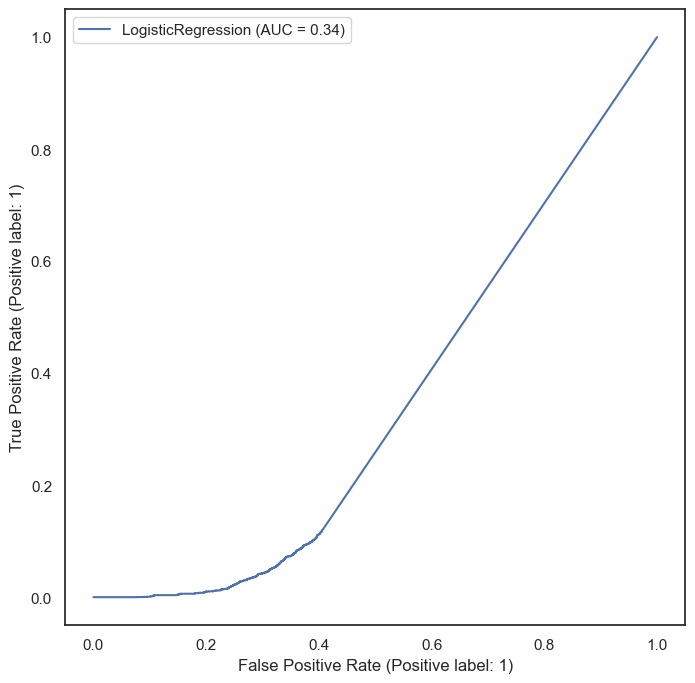

In [61]:
# 개별 roc 곡선
# fig = plt.figure(figsize=(8,8))
# fig.set_facecolor('white')
# ax = fig.add_subplot()
# RocCurveDisplay.from_estimator(good_lr, X, y, ax=ax)
# ax.plot([0, 1], [0, 1], color='red', label='Random Model')
# ax.legend()
# plt.show()

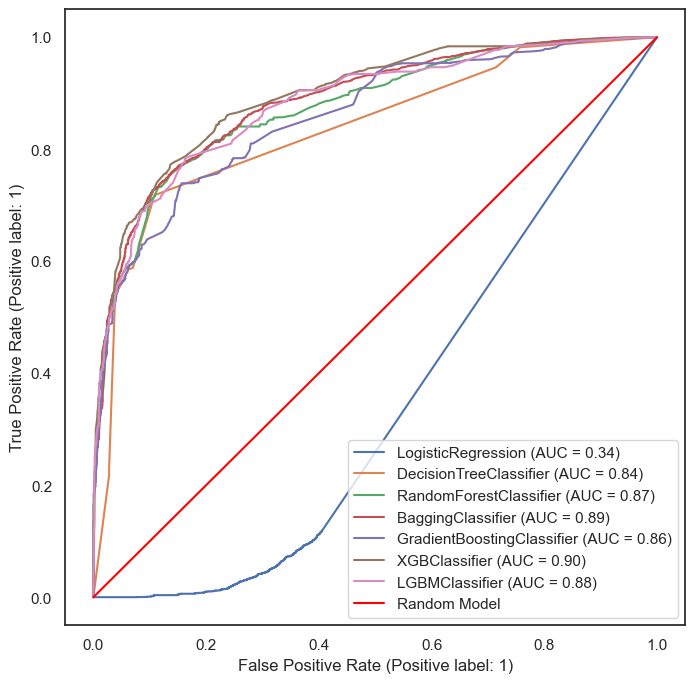

In [41]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
RocCurveDisplay.from_estimator(good_lr, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_dt, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_rf, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_bag, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_gb, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_xgb, X, y, ax=ax)
RocCurveDisplay.from_estimator(good_lgbm, X, y, ax=ax)
ax.plot([0, 1], [0, 1], color='red', label='Random Model')
ax.legend()
plt.show()